In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchtext
from torchtext.datasets import AG_NEWS
import os
from collections import Counter, OrderedDict
import myModel
import matplotlib.pyplot as plt

E:\anaconda\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 下载数据集, 并且观察数据形式
path = r'./data/datasets/AG_NEWS/'
os.makedirs('data', exist_ok=True)
train_dataset, test_dataset = AG_NEWS(root='./data', split=('train', 'test'))
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

for i, x in zip(range(5), train_dataset):
    print(f"**{classes[x[0] - 1]}** -> {x[1]}\n")

train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

# 使用dataloader读取给定的数据集
# 英语分词器
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

#
counter = Counter()
for (label, line) in train_dataset:
    counter.update(tokenizer(line))
# 将计数器中的项按照单词出现的次数进行降序排序，然后创建一个有序字典。
order_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
# 构建以word-indice为键值对的词表
vocab = torchtext.vocab.vocab(order_dict, min_freq=1)
vocab_size = len(vocab)
# print(vocab_size)


# 处理文本时要注意，句子长度可能会变化，我们可以填充为最大长度
def padify(b):
    # b is the list of tuples of length batch_size
    #   - first element of a tuple = label,
    #   - second = feature (text sequence)
    # build vectorized sequence
    v = [vocab.lookup_indices(tokenizer(x[1])) for x in b]
    # first, compute max length of a sequence in this minibatch
    l = max(map(len, v))
    return (  # tuple of two tensors - labels and features
        torch.LongTensor([t[0] - 1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t), (0, l - len(t)), mode='constant', value=0) for t in v]))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=padify, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=padify, shuffle=True)


Losses = []
Accuracies = []


def train_epoch(model, train_loader, lr, epoch_size=None, model_name=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    single_loss = []
    single_accuracy = []
    for epoch in range(epoch_size):
        model.train()
        total_loss = 0

        for labels, inputs in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for labels, inputs in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        single_loss.append(average_loss)
        single_accuracy.append(accuracy)
        print(f'Epoch [{epoch + 1}/{epoch_size}], Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2%}, '
              f'model name: {model_name}')

    Losses.append(single_loss)
    Accuracies.append(single_accuracy)

**Business** -> Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

**Business** -> Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

**Business** -> Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

**Business** -> Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

**Business** -> Oil prices soa

E:\anaconda\envs\Pytorch\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [3]:
epoch_size = 12
lr = 0.002
model = myModel.EmbedClassifier(vocab_size, embed_dim=32, hidden_dim=64, num_class=len(classes))
model.to(device)
train_epoch(model, train_loader, lr=0.001, epoch_size=epoch_size, model_name="EmbedClassifier")

Epoch [1/12], Loss: 0.6426, Validation Accuracy: 89.26%, model name: EmbedClassifier
Epoch [2/12], Loss: 0.3531, Validation Accuracy: 90.97%, model name: EmbedClassifier
Epoch [3/12], Loss: 0.3279, Validation Accuracy: 90.80%, model name: EmbedClassifier
Epoch [4/12], Loss: 0.3174, Validation Accuracy: 88.31%, model name: EmbedClassifier
Epoch [5/12], Loss: 0.3124, Validation Accuracy: 91.23%, model name: EmbedClassifier
Epoch [6/12], Loss: 0.3093, Validation Accuracy: 91.73%, model name: EmbedClassifier
Epoch [7/12], Loss: 0.3069, Validation Accuracy: 91.87%, model name: EmbedClassifier
Epoch [8/12], Loss: 0.3052, Validation Accuracy: 91.37%, model name: EmbedClassifier
Epoch [9/12], Loss: 0.3024, Validation Accuracy: 91.60%, model name: EmbedClassifier
Epoch [10/12], Loss: 0.3006, Validation Accuracy: 91.70%, model name: EmbedClassifier
Epoch [11/12], Loss: 0.2997, Validation Accuracy: 92.05%, model name: EmbedClassifier
Epoch [12/12], Loss: 0.2982, Validation Accuracy: 91.95%, model

In [4]:
model = myModel.RNNTextClassifier(vocab_size, 32, 64, len(classes))
model.to(device)
train_epoch(model, train_loader, lr=lr, epoch_size=epoch_size, model_name="RNNTextClassifier")

Epoch [1/12], Loss: 0.9620, Validation Accuracy: 69.51%, model name: RNNTextClassifier
Epoch [2/12], Loss: 0.8353, Validation Accuracy: 71.66%, model name: RNNTextClassifier
Epoch [3/12], Loss: 0.8046, Validation Accuracy: 72.87%, model name: RNNTextClassifier
Epoch [4/12], Loss: 0.7931, Validation Accuracy: 73.17%, model name: RNNTextClassifier
Epoch [5/12], Loss: 0.7832, Validation Accuracy: 73.05%, model name: RNNTextClassifier
Epoch [6/12], Loss: 0.7766, Validation Accuracy: 73.64%, model name: RNNTextClassifier
Epoch [7/12], Loss: 0.7738, Validation Accuracy: 73.64%, model name: RNNTextClassifier
Epoch [8/12], Loss: 0.7716, Validation Accuracy: 73.68%, model name: RNNTextClassifier
Epoch [9/12], Loss: 0.7754, Validation Accuracy: 71.91%, model name: RNNTextClassifier
Epoch [10/12], Loss: 0.7732, Validation Accuracy: 74.18%, model name: RNNTextClassifier
Epoch [11/12], Loss: 0.7698, Validation Accuracy: 73.60%, model name: RNNTextClassifier
Epoch [12/12], Loss: 0.7744, Validation A

In [5]:
num_filters = 100  # 卷积核数量
filter_sizes = [3, 4, 5]  # 卷积核大小列表
model = myModel.CNNTextClassifier(vocab_size, 32, num_filters, filter_sizes=filter_sizes, num_class=len(classes))
model.to(device)
train_epoch(model, train_loader, lr=lr, epoch_size=epoch_size, model_name="CNNTextClassifier")

Epoch [1/12], Loss: 0.4359, Validation Accuracy: 90.14%, model name: CNNTextClassifier
Epoch [2/12], Loss: 0.2937, Validation Accuracy: 91.50%, model name: CNNTextClassifier
Epoch [3/12], Loss: 0.2771, Validation Accuracy: 92.01%, model name: CNNTextClassifier
Epoch [4/12], Loss: 0.2678, Validation Accuracy: 92.20%, model name: CNNTextClassifier
Epoch [5/12], Loss: 0.2625, Validation Accuracy: 92.50%, model name: CNNTextClassifier
Epoch [6/12], Loss: 0.2578, Validation Accuracy: 92.49%, model name: CNNTextClassifier
Epoch [7/12], Loss: 0.2544, Validation Accuracy: 92.22%, model name: CNNTextClassifier
Epoch [8/12], Loss: 0.2519, Validation Accuracy: 92.44%, model name: CNNTextClassifier
Epoch [9/12], Loss: 0.2507, Validation Accuracy: 92.55%, model name: CNNTextClassifier
Epoch [10/12], Loss: 0.2491, Validation Accuracy: 92.66%, model name: CNNTextClassifier
Epoch [11/12], Loss: 0.2489, Validation Accuracy: 92.54%, model name: CNNTextClassifier
Epoch [12/12], Loss: 0.2485, Validation A

In [6]:
hidden_dim = 256  # Transformer隐藏层维度
num_heads = 8  # 注意力头数
num_layers = 4  # Transformer层数
model = myModel.TransformerClassifier(vocab_size, embed_dim=32, hidden_dim=hidden_dim, num_heads=num_heads,
                                      num_layers=num_layers,
                                      num_class=len(classes))
model.to(device)
train_epoch(model, train_loader, lr=0.001, epoch_size=epoch_size, model_name="TransformerTextClassifier")

Epoch [1/12], Loss: 0.5980, Validation Accuracy: 90.05%, model name: TransformerTextClassifier
Epoch [2/12], Loss: 0.2779, Validation Accuracy: 92.98%, model name: TransformerTextClassifier
Epoch [3/12], Loss: 0.2473, Validation Accuracy: 93.90%, model name: TransformerTextClassifier
Epoch [4/12], Loss: 0.2367, Validation Accuracy: 93.86%, model name: TransformerTextClassifier
Epoch [5/12], Loss: 0.2311, Validation Accuracy: 94.01%, model name: TransformerTextClassifier
Epoch [6/12], Loss: 0.2285, Validation Accuracy: 94.12%, model name: TransformerTextClassifier
Epoch [7/12], Loss: 0.2261, Validation Accuracy: 93.74%, model name: TransformerTextClassifier
Epoch [8/12], Loss: 0.2236, Validation Accuracy: 93.87%, model name: TransformerTextClassifier
Epoch [9/12], Loss: 0.2238, Validation Accuracy: 94.23%, model name: TransformerTextClassifier
Epoch [10/12], Loss: 0.2224, Validation Accuracy: 94.20%, model name: TransformerTextClassifier
Epoch [11/12], Loss: 0.2222, Validation Accuracy:

Text(0, 0.5, 'accuracy')

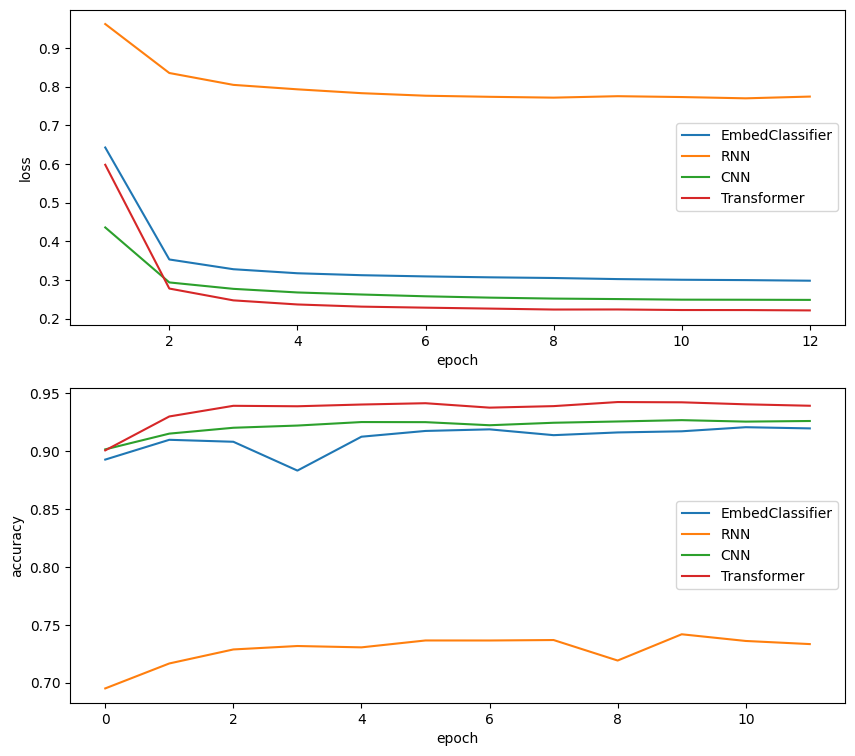

In [7]:
model_names = ["EmbedClassifier", "RNN", "CNN", "Transformer"]
fig = plt.figure(figsize=(10, 9))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for loss, accuracy, model_name in zip(Losses, Accuracies, model_names):
    ax1.plot(range(1, epoch_size + 1), loss, label=model_name)
    ax1.legend()
    
    ax2.plot(range(0, epoch_size), accuracy, label=model_name)
    ax2.legend()
    

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

    